In [1]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","readxl","RColorBrewer","surveillance")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

'%&%' = function(x,y)paste0(x,y)

theme_set(theme_bw())
version$version.string

This is surveillance 1.18.0. For overview type 'help(surveillance)'.



[1] "R version 4.0.0 Patched (2020-05-24 r78561)"

## Revision note

$\circ$ typo in the function of generation interval (shape parameter) was corrected. (15 May 2020)

$\circ$ assuming the proportion of asymptomatic cases among all cases is constant, the asymptomatic cases were included in the estimation of $R_t$ including all cases with unknown illness onset date. (16 May 2020)

## Data

For the analysis, all confirmed COVID-19 cases who diagnosed in Japan were categorized into two types of case, imported case and domestic transmission case. The imported cases were defined as (i) those who have international travel history, (ii) who embarked on the “Diamond Princess” cruise ship as a passenger or member of disaster assistance team (i.e., DMAT or PMAT) within two weeks before the illness onset. 

For the estimation of $R_t$, the symptomatic confirmed cases in Japan with either or both the date of illness onset or the date of laboratory confirmation were used. Since the cases from the chartered flights have not involved in the domestic transmission dynamics in Japan, those cases were excluded in the analysis.

In [2]:
## The code was written by Sung-mok Jung

## load the data
datestar = as.Date("2020-05-10")
read.csv("../data/JapaneseDataCOVID19 ("%&%format(datestar,"%y%m%d")%&%").csv", encoding="UTF-8") -> master_df 
colnames(master_df) <- c("type","onset", "labconf", "reported", "asym")
master_df %<>% mutate(labconf = as.Date(labconf), onset = as.Date(onset), reported = as.Date(reported))


## data for cases with the illness onset
master_df %>% filter(!is.na(onset)) -> onset_Japan
onset_Japan %>% group_by(onset) %>% count(type) %>% spread(type, n) %>% as.data.frame() -> master_dff
master_dff[is.na(master_dff)] <- 0 
master_dff$onset <- as.Date(master_dff$onset)
    
as.numeric(datestar-1-min(master_dff$onset)) -> time.diff
ttime <- as.data.frame(c(0:time.diff))
colnames(ttime) <- c('t')
ttime %<>% mutate(onset = as.Date(min(onset_Japan$onset))+t)
    
merge(ttime, master_dff, by='onset', all.x=TRUE) -> master_df_final
master_df_final[is.na(master_df_final)] <- 0
    
master_df_final %<>% mutate(total = domestic+imported) %>% dplyr::select(onset, domestic, imported, total) %>%
rename(domestic_org = domestic, imported_org = imported)
master_df_final -> entire_Japan


## data for cases with the unknown illness onset (excluding the asymptomatic cases)
master_df %>% filter(is.na(onset)) %>% filter(!is.na(labconf)) -> unknown_df
unknown_df %>% group_by(labconf) %>% count(type) %>% spread(type, n) %>% as.data.frame() -> unknown_dff
unknown_dff[is.na(unknown_dff)] <- 0 
unknown_dff$labconf <- as.Date(unknown_dff$labconf)
    
as.numeric(datestar-1-min(unknown_dff$labconf)) -> time.diff
ttime <- as.data.frame(c(0:time.diff))
colnames(ttime) <- c('t')
ttime %<>% mutate(labconf = as.Date(min(unknown_df$labconf))+t)
merge(ttime, unknown_dff, by='labconf', all.x=TRUE) -> unknown_df_final
unknown_df_final[is.na(unknown_df_final)] <- 0
    
unknown_df_final %<>% mutate(total=domestic+imported) %>% dplyr::select(labconf, domestic, imported, total)

temp_start <- matrix(NA, ncol=1, nrow=as.numeric(min(unknown_df_final$labconf)-as.Date("2020-01-03")))
temp_start %<>% as.data.frame() %>% mutate(labconf = as.Date(as.Date("2020-01-03"):(min(unknown_df_final$labconf)-1), origin="1970-01-01"),
                                           domestic = 0, imported = 0, total= 0) %>% dplyr::select(-V1)
rbind(temp_start, unknown_df_final) -> unknown_Japan

## Distributions

### 1. Generation time
In the present analysis, serial interval was assumed to be identical with generation time and the value of doubly interval censored serial interval was also adopted from the previous study (Nishiura et, al., 2020, IJID). The Weibull distribution was fitted to 28 known infector-infectee pairs (mean = 4.8  days, standard deviation = 2.3 days).


### 2. Incubation period
We accounted for right truncation and modeled and used a lognormal distribution with parameters adopted from an earlier study (Linton et, al., 2020, JCM), and the estimated mean and SD were 5.6 days and 3.9 days, respectively.


### 3. Right-truncated reporting delay
We fitted the right-truncated time delay distribution from the illness onset to reporting to the Weibull distribution. We define the likelihood as follows: 

$$
L(\theta|S_k,O_k,T)=\prod_{k=1}^{K}\frac{h(S_k-O_k  |  \theta)}{H(T-O_k  |  \theta)}
$$

where $S_k$ and $O_k$ are the reporting date and the date of illness onset of case $k$, respectively and $T$ is the latest calendar day of observation. $h(∙)$ and $H(∙)$ are the probability density function (PDF) and cumulative density function (CDF) of Weibull distribution and $\theta$ is the parameters of the distribution (i.e., shape and scale). The likelihood is maximized to determine the best-fit parameters used in the estimation of the reproduction number ($R_t$).


In [3]:
## Serial interval (Nishiura, et al, 2020)
gi_fit = list(shape=2.305, scale=5.452)
generation <- function(t){pweibull(t, shape = gi_fit$shape, scale = gi_fit$scale) - 
                          pweibull(t-1, shape = gi_fit$shape, scale = gi_fit$scale)}


## incubation period (Linton et al, 2020)
inc_fit = list(meanlog=1.519, sdlog=0.615)
incubation <- function(t){plnorm(t, inc_fit$meanlog, inc_fit$sdlog) - plnorm(t-1, inc_fit$meanlog, inc_fit$sdlog)}


## right-truncated reporting delay from illness onset to laboratory confirmation (estimated values using the MHLW data)
rep_fit = list(shape=1.741, scale=8.573)
onsettolabconf <- function(t){pweibull(t,  shape=rep_fit$shape, scale=rep_fit$scale) - 
                              pweibull(t-1, shape=rep_fit$shape, scale=rep_fit$scale)}

## Back-projection from the laboratory confirmation date to illness onset

To estimate the effective reproduction number ($R_t$) by time of infection, we back-projected the cases by time of infection.

First, since there are some reported cases with unknown illness onset date, we back-projected those cases from laboratory confirmation date to illness onset date, using the PDF of time delay from the illness onset to laboratory confirmation. $R$ package ‘$surveillance$’ was used for the back-projection and within the package, the non-parametric back-projection algorithm based on Expectation-Maximization-Smoothing (EMS) algorithm was conducted.

In [4]:
## adding extra 10 days for the stability of back-projection procedure
temp_lastdays <- matrix(NA, ncol=1, nrow=10)
temp_lastdays %<>% as.data.frame() %>% mutate(labconf=as.Date((max(unknown_Japan$labconf)+1):(max(unknown_Japan$labconf)+10), origin="1970-01-01"),
                                              domestic=0, imported=0, total=0) %>% dplyr::select(-V1)
rbind(unknown_Japan, temp_lastdays) -> unknown_Japan
unknown_Japan %<>% mutate(time_onset = 1:nrow(unknown_Japan))


## time delay from the illness onset to laboratory confirmation
K = nrow(unknown_Japan)

report_probability = pweibull(1:K, shape=rep_fit$shape, scale=rep_fit$scale) - pweibull(1:K-1, shape=rep_fit$shape, scale=rep_fit$scale)
report_pmf = c(0,report_probability[1:21])


## back-projecton of imported cases
sts = new("sts", epoch=unknown_Japan$time_onset, observed=unknown_Japan$imported)
bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), 
                    Tmark = nrow(sts), B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, eq3a.method = c("R","C"))
sts_bp = backprojNP(sts, incu.pmf=report_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
unknown_Japan$imported_backproj = upperbound(sts_bp)


## back-projecton of domestic cases
sts = new("sts", epoch=unknown_Japan$time_onset, observed=unknown_Japan$domestic)
bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), 
                    Tmark = nrow(sts), B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                    eq3a.method = c("R","C"))
sts_bp = backprojNP(sts, incu.pmf=report_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
unknown_Japan$domestic_backproj = upperbound(sts_bp)


## normalizing the back-projected cases
unknown_Japan$imported_backproj[unknown_Japan$imported_backproj<=0.01] <- 0
unknown_Japan$domestic_backproj[unknown_Japan$domestic_backproj<=0.01] <- 0

unknown_Japan %>% mutate(imported_normal = imported_backproj/sum(imported_backproj)*sum(imported),
                         domestic_normal = domestic_backproj/sum(domestic_backproj)*sum(domestic),
                         total = imported_normal+domestic_normal,
                         time_onset=0:(nrow(unknown_Japan)-1)) %>%
dplyr::select(time_onset, labconf, imported_normal, domestic_normal, total) %>% 
rename(t = time_onset, onset = labconf, imported_backproj=imported_normal, domestic_backproj = domestic_normal) -> dt.backproj_onset

In [5]:
## merge the back-projected data with cases whose date of illness onset was available
merge(entire_Japan, dt.backproj_onset, by=c('onset'), all.y=TRUE) %>% 
mutate(domestic = domestic_org+domestic_backproj, imported = imported_org + imported_backproj,
       total = domestic + imported) %>% dplyr::select(onset, domestic, imported ,total) -> df_onset
df_onset[is.na(df_onset)] <- 0

## Back-projection from the illness onset to time of infection

The epidemic curve by date of illness onset was back-projected once again to the epidemic curve by the time of infection, using the PDF of incubation and the same back-projection method was used.

In [6]:
## adding extra 10 days for the stability of back-projection procedure
temp_lastdays <- matrix(NA, ncol=1, nrow=10)
temp_lastdays %<>% as.data.frame() %>% mutate(onset=as.Date((max(df_onset$onset)+1):(max(df_onset$onset)+10), origin="1970-01-01"),
                                              domestic=0, imported=0, total=0) %>% dplyr::select(-V1)
rbind(df_onset, temp_lastdays) -> df_onset
df_onset %<>% mutate(time_onset = 1:nrow(df_onset))


## incubation period
K = nrow(df_onset)
incubation_probability = plnorm(1:K, inc_fit$meanlog, inc_fit$sdlog) - plnorm(1:K-1, inc_fit$meanlog, inc_fit$sdlog)
inc_pmf = c(0,incubation_probability[1:21])


## back-projecton of imported cases
sts = new("sts", epoch=df_onset$time_onset, observed=df_onset$imported)
bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), 
                    Tmark = nrow(sts), B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, eq3a.method = c("R","C"))
sts_bp = backprojNP(sts, incu.pmf=inc_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
df_onset$imported_backproj = upperbound(sts_bp)


## back-projecton of domestic cases
sts = new("sts", epoch=df_onset$time_onset, observed=df_onset$domestic)
bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), 
                    Tmark = nrow(sts), B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                    eq3a.method = c("R","C"))
sts_bp = backprojNP(sts, incu.pmf=inc_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
df_onset$domestic_backproj = upperbound(sts_bp)


## normalizing the back-projected cases
df_onset$imported_backproj[df_onset$imported_backproj<=0.01] <- 0
df_onset$domestic_backproj[df_onset$domestic_backproj<=0.01] <- 0

df_onset %>% mutate(imported_normal = imported_backproj/sum(imported_backproj)*sum(imported),
                    domestic_normal = domestic_backproj/sum(domestic_backproj)*sum(domestic),
                    total = imported_normal+domestic_normal,
                    time_onset=0:(nrow(df_onset)-1)) %>%
dplyr::select(time_onset, onset, imported_normal, domestic_normal, total) %>% 
rename(t = time_onset, imported=imported_normal, domestic = domestic_normal) %>% filter(onset <= (datestar-1))-> dt.backproj

## Renewal equation

Let $C_{domestic} (t)$ be the number of newly domestic infected cases (i.e., defined as confirmed COVID-19 cases who were infected within the Japan) on day $t$. Then, the expected number of domestic infected case is modelled as:
$$
E(C_{domestic} (t))=R_t \sum_{\tau=1}^{t-1}C_{total} (t-\tau)g(\tau)  \frac{F(T-t)}{F(T-t+\tau)},
$$
where $C_{total} (t)$ is the number of total infected COVID-19 cases (i.e., sum of domestic infections and imported infections) on day $t$, $R_t$ is the reproduction number on day $t$ and $g(∙)$ is the PDF of generation interval distribution. In addition, to account for right-censoring, i.e., cases that have not yet been reported but already infected, $F(∙)$, the CDF of time delay from infection to reporting (i.e., the convolution of PDF of incubation period and PDF of right-truncated reporting delay from the illness onset to reporting) was considered. 

To estimate parameters governing $C_{total} (t-\tau)g(\tau)\frac{F(T-t)}{F(T-t+\tau)}$, we assumed that $C_{domestic} (t)$ follows a Poisson distribution and we arrived at the likelihood function of the form:
$$
L(R_t;C_{domestic} (t))= \prod_{t=1}^{T}\frac{\exp⁡(-E(C_{domestic} (t)) E(C_{domestic}  (t))^{C_{domestic}(t)}}{C_{domestic}  (t)!}.
$$

The 95% confidence intervals of each estimates were derived using the profile likelihood.

In [7]:
today = as.numeric(datestar-as.Date(min(dt.backproj$onset)))

## start estimation from 1 Feb 2020, as there is a huge uncertainty in the early phage of epidemic
Start.T = 29


## reporting delay distribution from infection to lab confirmation
infectiontoreport <- function(t, tau){sum(convolve(onsettolabconf(1:today-t+tau),rev(incubation(1:today-t+tau)),type = c("open")))}


## pre-calculation for reporting delay to reduce the calculation time
precal <- matrix(0, nrow=(max(dt.backproj$t)-Start.T+2+1), ncol=(max(dt.backproj$t)-1))
for (m in (Start.T-2):max(dt.backproj$t)){
    for (n in 1:m-1){precal[m-Start.T+2+1,n] <- infectiontoreport(m,n)}}

delay_precalculation <- function(t){sum(convolve(onsettolabconf(1:(today-t)),rev(incubation(1:(today-t))),type = c("open")))}

dt.backproj %<>% rowwise %>%
mutate(imported_delay = imported/delay_precalculation(t),
       domestic_delay = domestic/delay_precalculation(t)) %>% mutate(total=imported_delay+domestic_delay)

In [8]:
## estimating Rt
est.t <- list()
est.CI <- list()

for (TT in Start.T:max(dt.backproj$t)){  
    
    dt.backproj %>% filter(t <= TT) -> dt.backproj.T
    
    llk <- function(param){
 
        llk <- 0; Cs <- 0  
        t=TT; R = param

        Css <- rep(0, t)    

        for (tau in 1:t-1){Css[tau] = (dt.backproj.T$total[t-tau+1])*generation(tau)/precal[t-Start.T+3,tau]}

        Cs = sum(Css)*R 
        Cs[Cs<=0] <- 1e-5

        return(-(-Cs+dt.backproj.T$domestic_delay[t+1]*log(Cs)-lgamma(dt.backproj.T$domestic_delay[t+1]+1))) 
    }  

    param0 = c(0.7)
    opt_est <- optim(param0, fn=llk, method=c("L-BFGS-B"), lower=c(0), control=list(maxit=10000))
    opt_est$par -> est.t[[TT]]

    ## 95% confidence intervals using the profile likelihood
    ci_pro <- matrix(NA, ncol=2, nrow=1)

    CI <- function(par_CI){return(2*(-llk(par_CI)+opt_est$value))} #llk

    par_CI <- seq(0, 10, by = 0.01)
    
    logLik <- sapply(par_CI, FUN = CI)
    as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik


    cbind(par_CI, logLik) -> data_CI

    data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
    data_CI %<>% na.omit()

    min(data_CI$par_CI) -> ci_pro[1,1]
    max(data_CI$par_CI) -> ci_pro[1,2]
    
    as.data.frame(ci_pro) -> ci_pro
    colnames(ci_pro) <- c("lower","upper")    
    ci_pro -> est.CI[[TT]]
}

matrix(unlist(est.t),ncol=1,byrow=T) -> est.t
matrix(unlist(est.CI),ncol=2,byrow=T) -> est.CI

cbind(est.t, est.CI) -> est

## Figures for the estimated Rt

In [9]:
est %>% as.data.frame() %>% mutate(t = Start.T:max(dt.backproj$t)) -> result
merge(dt.backproj, result, by='t', all.x=TRUE) -> result
colnames(result) <- c("t","onset","imported","domestic","total","imported_delay","domestic_delay","Rt","lower","upper")

result %>% filter(onset<=as.Date(datestar-(17))) -> result_withcut

result_withcut %>% dplyr::select(onset, domestic, imported) %>% gather(onset) -> figure_data
result_withcut %>% dplyr::select(onset) -> TIME
rbind(TIME, TIME) -> TIME
cbind(figure_data, TIME) -> figure_data
colnames(figure_data) <- c("subject","value","onset")

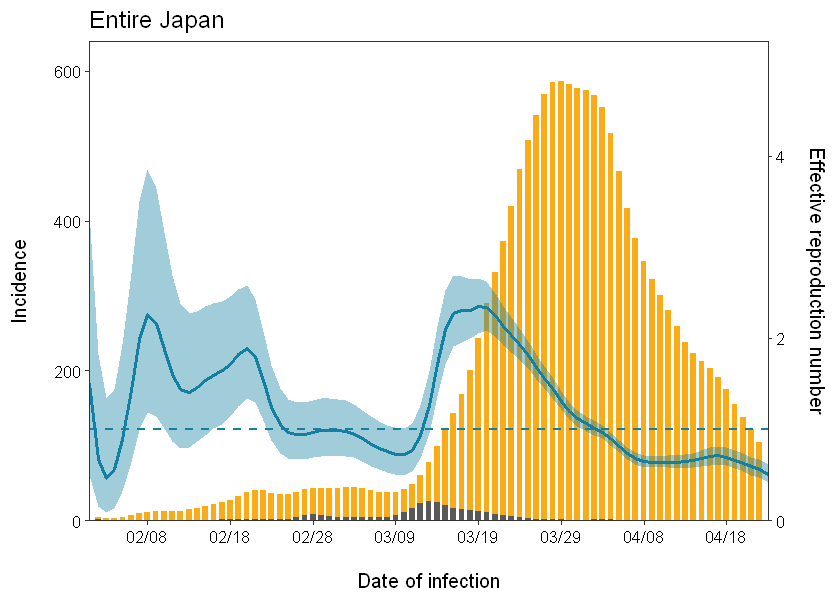

In [10]:
options(repr.plot.width=7,repr.plot.height=5)

scaling_parameter=max(result_withcut$total)/max(result_withcut$upper[!is.na(result_withcut$upper)])
range = c(as.Date("2020-02-01"), (datestar-17))
adj = 0.8
options(warn=-1)

figure_data %>% 
    ggplot() + 
    geom_bar(aes(x=onset, y=value, fill=subject, group=subject),stat='identity', width=0.7) +
    scale_fill_manual(values=c("#FAAB18","gray35")) +
    geom_line(data=result[!is.na(result$Rt),],aes(x=onset,y=Rt*scaling_parameter*adj),color="#1380A1",size=1) +
    geom_ribbon(data=result,aes(ymax=result$upper*scaling_parameter*adj, ymin=result$lower*scaling_parameter*adj, x=onset), 
                fill="#1380A1", alpha = 0.4) +
    ggtitle("Entire Japan") +
    labs(x="\nDate of infection", y="Incidence\n") +
    theme(text=element_text(size=12, family="sans",color="black"),
          axis.text=element_text(size=10, family="sans",color="black"),
          panel.grid.major=element_blank(), panel.grid.minor = element_blank(),
         legend.position="none") +
    scale_x_date(date_labels="%m/%d",date_breaks="10 day", limits=range, expand=c(0, 0)) +
    scale_y_continuous(limit=c(0,640), expand = c(0, 0),
                       sec.axis = sec_axis(~./(scaling_parameter*adj), breaks=c(0,2,4,6,8,10), name="Effective reproduction number\n")) +
    geom_hline(yintercept=1*scaling_parameter*adj, linetype="dashed", color = "#1380A1", size =0.7)

## Estimating Rt excluding the cases with unknown illness onset date

In [11]:
entire_Japan %>% rename(domestic = domestic_org, imported = imported_org) -> df_onset_wo

## adding extra 10 days for the stability of back-projection procedure
temp_lastdays <- matrix(NA, ncol=1, nrow=10)
temp_lastdays %<>% as.data.frame() %>% mutate(onset=as.Date((max(df_onset_wo$onset)+1):(max(df_onset_wo$onset)+10), origin="1970-01-01"),
                                              domestic=0, imported=0, total=0) %>% dplyr::select(-V1)
rbind(df_onset_wo, temp_lastdays) -> df_onset_wo
df_onset_wo %<>% mutate(time_onset = 1:nrow(df_onset_wo))


## incubation period
K = nrow(df_onset_wo)
incubation_probability = plnorm(1:K, inc_fit$meanlog, inc_fit$sdlog) - plnorm(1:K-1, inc_fit$meanlog, inc_fit$sdlog)
inc_pmf = c(0,incubation_probability[1:21])


## back-projecton of imported cases
sts = new("sts", epoch=df_onset_wo$time_onset, observed=df_onset_wo$imported)
bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), 
                    Tmark = nrow(sts), B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, eq3a.method = c("R","C"))
sts_bp = backprojNP(sts, incu.pmf=inc_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
df_onset_wo$imported_backproj = upperbound(sts_bp)


## back-projecton of domestic cases
sts = new("sts", epoch=df_onset_wo$time_onset, observed=df_onset_wo$domestic)
bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), 
                    Tmark = nrow(sts), B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                    eq3a.method = c("R","C"))
sts_bp = backprojNP(sts, incu.pmf=inc_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
df_onset_wo$domestic_backproj = upperbound(sts_bp)


## normalizing the back-projected cases
df_onset_wo$imported_backproj[df_onset_wo$imported_backproj<=0.01] <- 0
df_onset_wo$domestic_backproj[df_onset_wo$domestic_backproj<=0.01] <- 0

df_onset_wo %>% mutate(imported_normal = imported_backproj/sum(imported_backproj)*sum(imported),
                       domestic_normal = domestic_backproj/sum(domestic_backproj)*sum(domestic),
                       total = imported_normal+domestic_normal,
                       time_onset=0:(nrow(df_onset_wo)-1)) %>%
dplyr::select(time_onset, onset, imported_normal, domestic_normal, total) %>% 
rename(t = time_onset, imported=imported_normal, domestic = domestic_normal) %>% filter(onset <= (datestar-1))-> dt.backproj

In [12]:
today = as.numeric(datestar-as.Date(min(dt.backproj$onset)))

## start estimation from 1 Feb 2020, as there is a huge uncertainty in the early phage of epidemic
Start.T = 29


## reporting delay distribution from infection to lab confirmation
infectiontoreport <- function(t, tau){sum(convolve(onsettolabconf(1:today-t+tau),rev(incubation(1:today-t+tau)),type = c("open")))}


## pre-calculation for reporting delay to reduce the calculation time
precal <- matrix(0, nrow=(max(dt.backproj$t)-Start.T+2+1), ncol=(max(dt.backproj$t)-1))
for (m in (Start.T-2):max(dt.backproj$t)){
    for (n in 1:m-1){precal[m-Start.T+2+1,n] <- infectiontoreport(m,n)}}

delay_precalculation <- function(t){sum(convolve(onsettolabconf(1:(today-t)),rev(incubation(1:(today-t))),type = c("open")))}

dt.backproj %<>% rowwise %>%
mutate(imported_delay = imported/delay_precalculation(t),
       domestic_delay = domestic/delay_precalculation(t)) %>% mutate(total=imported_delay+domestic_delay)

In [13]:
## estimating Rt
est.t <- list()
est.CI <- list()

for (TT in Start.T:max(dt.backproj$t)){  
    
    dt.backproj %>% filter(t <= TT) -> dt.backproj.T
    
    llk <- function(param){

        llk <- 0; Cs <- 0  
        t=TT; R = param

        Css <- rep(0, t)    

        for (tau in 1:t-1){Css[tau] = (dt.backproj.T$total[t-tau+1])*generation(tau)/precal[t-Start.T+3,tau]}

        Cs = sum(Css)*R 
        Cs[Cs<=0] <- 1e-5

        return(-(-Cs+dt.backproj.T$domestic_delay[t+1]*log(Cs)-lgamma(dt.backproj.T$domestic_delay[t+1]+1)))
    }  

    param0 = c(0.7)
    opt_est <- optim(param0, fn=llk, method=c("L-BFGS-B"), lower=c(0), control=list(maxit=10000))
    opt_est$par -> est.t[[TT]]


    ## 95% confidence intervals using the profile likelihood
    ci_pro <- matrix(NA, ncol=2, nrow=1)

    CI <- function(par_CI){return(2*(-llk(par_CI)+opt_est$value))} #llk()

    par_CI <- seq(0, 10, by = 0.01)
    
    logLik <- sapply(par_CI, FUN = CI)
    as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik


    cbind(par_CI, logLik) -> data_CI

    data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
    data_CI %<>% na.omit()

    min(data_CI$par_CI) -> ci_pro[1,1]
    max(data_CI$par_CI) -> ci_pro[1,2]
    
    as.data.frame(ci_pro) -> ci_pro
    colnames(ci_pro) <- c("lower","upper")    
    ci_pro -> est.CI[[TT]]
}

matrix(unlist(est.t),ncol=1,byrow=T) -> est.t
matrix(unlist(est.CI),ncol=2,byrow=T) -> est.CI

cbind(est.t, est.CI) -> est

In [14]:
est %>% as.data.frame() %>% mutate(t = Start.T:max(dt.backproj$t)) -> result
merge(dt.backproj, result, by='t', all.x=TRUE) -> result
colnames(result) <- c("t","onset","imported","domestic","total","imported_delay","domestic_delay","Rt","lower","upper")

result %>% filter(onset<=as.Date(datestar-(17))) -> result_withcut

result_withcut %>% dplyr::select(onset, domestic, imported) %>% gather(onset) -> figure_data
result_withcut %>% dplyr::select(onset) -> TIME
rbind(TIME, TIME) -> TIME
cbind(figure_data, TIME) -> figure_data
colnames(figure_data) <- c("subject","value","onset")

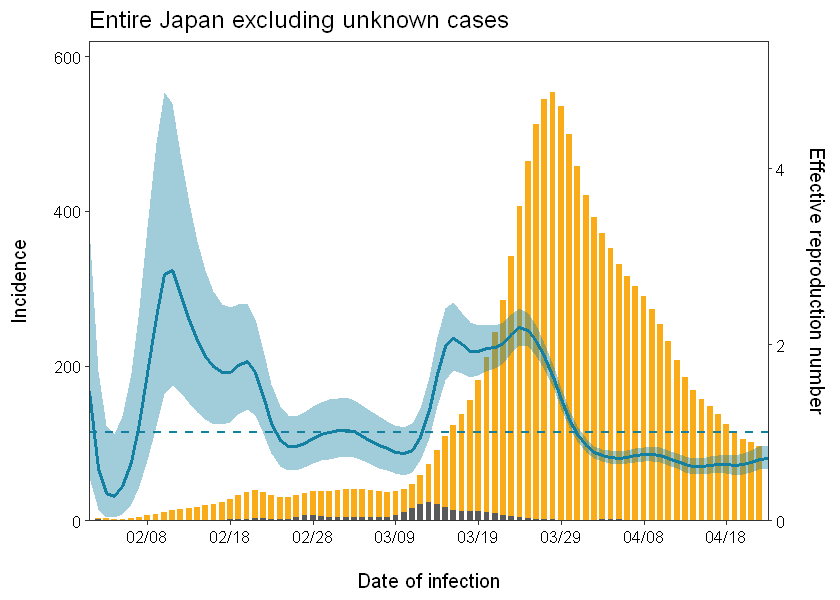

In [15]:
scaling_parameter=max(result_withcut$total)/max(result_withcut$upper[!is.na(result_withcut$upper)])
range = c(as.Date("2020-02-01"), (datestar-17))
options(warn=-1)

figure_data %>% 
    ggplot() + 
    geom_bar(aes(x=onset, y=value, fill=subject, group=subject),stat='identity', width=0.7) +
    scale_fill_manual(values=c("#FAAB18","gray35")) +
    geom_line(data=result[!is.na(result$Rt),],aes(x=onset,y=Rt*scaling_parameter),color="#1380A1",size=1) +
    geom_ribbon(data=result,aes(ymax=result$upper*scaling_parameter, ymin=result$lower*scaling_parameter, x=onset), 
                fill="#1380A1", alpha = 0.4) +
    ggtitle("Entire Japan excluding unknown cases") +
    labs(x="\nDate of infection", y="Incidence\n") +
    theme(text=element_text(size=12, family="sans",color="black"),
          axis.text=element_text(size=10, family="sans",color="black"),
          panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
         legend.position="none") +
    scale_x_date(date_labels="%m/%d",date_breaks="10 day", limits=range, expand=c(0, 0)) +
    scale_y_continuous(limit=c(0,620), expand = c(0, 0),
                       sec.axis=sec_axis(~./(scaling_parameter), breaks=c(0,2,4,6,8,10), name="Effective reproduction number\n")) +
    geom_hline(yintercept=1*scaling_parameter, linetype="dashed", color = "#1380A1", size =0.7)

In [16]:
write.csv(result, '../results/rtmle.csv')
write.csv(result_withcut, '../results/rtwcmle.csv')